In [1]:
# Python Free Fermion Large Scale Simulation Platform (FreeFermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
import os
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse, \
    mnist_single_pdf, mix_rbf_kernel, kernel_expect, mnist_single_binary

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math
import seaborn as sns


import torch
import matplotlib.pyplot as plt
import qiskit
import numpy as np

In [3]:
q_data, data_digit = mnist_single_pdf(9, 17, 14)
q_data_img = (q_data>0.001).int()
q_data = q_data_img.flatten().unsqueeze(0)

In [4]:
q_data

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.int32)

In [5]:
print('sum', torch.sum(q_data))

sum tensor(68)


In [6]:
q_data

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0]], dtype=torch.int32)

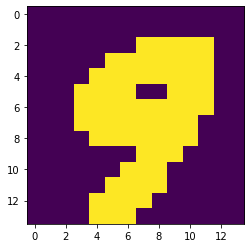

In [7]:
plt.imshow(q_data_img)

In [8]:
q_data.shape

torch.Size([1, 196])

In [9]:
n_fermions = 68
factor = 1
N = 14**2
# basis_m_n = binary_basis(geometry=(n_fermions,)) # The basis in the probability space

conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*1

print('conn_list', conn_list)
L = len(conn_list) # Number of layers

# 101010...10
x_input = torch.tensor([[1,0]*(n_fermions)+[0]*(N-2*n_fermions)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# Initialize the circuit
circuit = Network(conn_list, N)
print('circuit.parameters()', circuit.parameters())

# Initialize the circuit
circuit = Network(conn_list, N)

beta1 = 0.5
lr_G = 1e-1
optimizerG = torch.optim.Adam(circuit.parameters(), lr=lr_G, betas=(beta1, 0.999)) #The parameters are the th
def kl(p_data, probs_batch):
    return torch.sum(p_data * torch.log(p_data/(probs_batch+1e-12)))
def tv_sqr(p_data, probs_batch):
    return torch.sum(torch.square(probs_batch-p_data))


# MMD loss by tracking the full probability space [0.5, 0.1, 0.2, 0.25,4,10]
# K = torch.tensor(mix_rbf_kernel(basis_m_n, basis_m_n, sigma_list=[0.002, 0.5, 0.1, 0.2, 0.25,4,10]), dtype=torch.float)
def exact_mmd(pdf_data, pdf_model): #input are tensors
    # print('debug pdf_data', pdf_data)
    # print('debug pdf_model', pdf_model)
    # parmas_L_by_4 = parmas_L_times_4.reshape((L, 4))
    # bij_vec = parmas_L_by_4[:,2]+parmas_L_by_4[:,3]*1j # the bij has a real part and a complex part
    # params_L_3 = np.concatenate((parmas_L_by_4[:,0:2], bij_vec[:,None]), axis=1)
    p_diff = pdf_data-pdf_model # Although this puts a constant term to the loss value, it is easier to code this way
    return kernel_expect(K, p_diff, p_diff)



conn_list [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [96, 97], [98, 99], [100, 101], [102, 103], [104, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119], [120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 143], [144, 145], [146, 147], [148, 149], [150, 151], [152, 153], [154, 155], [156, 157], [158, 159], [160, 161], [162, 163], [164, 165], [166, 167], [168, 169], [170, 171], [172, 173], [174, 175], [176, 177], [178, 179], [180, 181], [182, 1

In [10]:
y_batch = q_data # data pattern
x_batch = x_input
sub_mask_batch = (torch.tensor([ [1]*(N) ])).repeat(y_batch.shape[0], 1)
ts = time.time()
probs_batch = circuit.forward(y_batch, x_batch)
tf = time.time()
print('total time', tf-ts)
probs_batch

total time 0.749565839767456


tensor([-0.+0.j], grad_fn=<LinalgDetBackward0>)

In [11]:
prob_list = []
for itr in range(20):
    circuit.zero_grad() # clear the parameter gradients
    y_batch = q_data # data pattern
    x_batch = q_data
    sub_mask_batch = (torch.tensor([ [1]*(N) ])).repeat(y_batch.shape[0], 1)
    ts = time.time()
    probs_batch = -torch.abs(circuit.forward(y_batch, x_batch))
    print('iter, obj', (itr, probs_batch))
    
    probs_batch.backward()
    optimizerG.step()
    tf = time.time()
    print('total time', tf-ts)
    prob_list.append(probs_batch)
#     print('gradients', )
#     grads_l_list = []
#     for l in range(L):
#         # each layer has four parameters
#         grads_l = np.array([[circuit.V_l_module_list[l].bii.grad.detach().numpy()[0], circuit.V_l_module_list[l].bjj.grad.detach().numpy()[0],\
#          circuit.V_l_module_list[l].bij_real.grad.detach().numpy()[0], \
#         circuit.V_l_module_list[l].bij_img.grad.detach().numpy()[0]]])

        
#         grads_l_list.append(grads_l)
#     print(grads_l_list)

iter, obj (0, tensor([-2.1477e-06], grad_fn=<NegBackward0>))
total time 3.7665388584136963
iter, obj (1, tensor([-0.0001], grad_fn=<NegBackward0>))
total time 3.7750461101531982
iter, obj (2, tensor([-0.0017], grad_fn=<NegBackward0>))
total time 3.7788751125335693
iter, obj (3, tensor([-0.0147], grad_fn=<NegBackward0>))
total time 3.795121192932129
iter, obj (4, tensor([-0.0759], grad_fn=<NegBackward0>))
total time 3.8551371097564697
iter, obj (5, tensor([-0.2523], grad_fn=<NegBackward0>))
total time 4.313345909118652
iter, obj (6, tensor([-0.5461], grad_fn=<NegBackward0>))
total time 4.088526248931885
iter, obj (7, tensor([-0.7872], grad_fn=<NegBackward0>))
total time 3.9280078411102295
iter, obj (8, tensor([-0.8973], grad_fn=<NegBackward0>))
total time 5.18551778793335
iter, obj (9, tensor([-0.9573], grad_fn=<NegBackward0>))
total time 4.683943748474121
iter, obj (10, tensor([-0.9756], grad_fn=<NegBackward0>))
total time 4.842832326889038
iter, obj (11, tensor([-0.9913], grad_fn=<Neg

/var/folders/66/87ywc69x2c5_cqkhm3p3f4l00000gn/T/ipykernel_65893/1741912902.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_list = torch.tensor(prob_list)


Text(0.5, 1.0, 'prob of outputing target pattern')

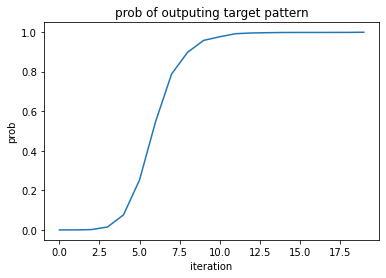

In [15]:
prob_list = torch.tensor(prob_list)
plt.plot(-prob_list)
plt.xlabel('iteration')
plt.ylabel('prob')
plt.title('prob of outputing target pattern')